**Goal of the project**

Getting the free delivery threshold right is a big deal: 60% of ecommerce companies cite “free delivery with conditions” as their most successful marketing tool. And the reason is simple — free delivery is incredibly effective at boosting average order value. In fact, 3 out of 4 customers admit to adding an extra item or two to their cart to qualify.

Free delivery is a powerful motivator, but it’s also expensive. This makes it imperative to get the balance right. We want to find that sweet spot where customers are motivated to spend a bit more to hit the free delivery threshold, without making it so high that they abandon the purchase completely.

**Load the packages**

In [28]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [29]:
%config InlineBackend.figure_format = 'retina'
sns.set_context('notebook')
sns.set(rc = {'figure.figsize': (15, 6)})

**Load the data**

To find a free delivery threshold we first need a transaction item dataset. Transaction item data is readily available from most ecommerce platforms or finance systems, but we’ll use the [Online Business Sales 2017-2019 Dataset](https://www.kaggle.com/datasets/tylermorse/retail-business-sales-20172019).

In [30]:
# Load dataset
df = pd.read_csv('../input/retail-business-sales-20172019/business.retailsales.csv')

In [31]:
# Rename Pandas columns to lower case
df.columns = df.columns.str.lower()

In [32]:
# Drop unnecessary columns
df = df[['product type', 'gross sales']]

In [33]:
# Rename column 'gross sales'
df.rename({'gross sales': 'gross revenue ($)'}, axis = 1, inplace = True)

In [34]:
# Examine the data
df.head()

,product type,gross revenue ($)
0,Art & Sculpture,14935.0
1,Basket,3744.0
2,Basket,3825.0
3,Basket,3035.0
4,Art & Sculpture,2696.8


In [35]:
# Overview of all variables, their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1775 entries, 0 to 1774
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   product type       1767 non-null   object 
 1   gross revenue ($)  1775 non-null   float64
dtypes: float64(1), object(1)
memory usage: 27.9+ KB


**Preprocessing the data**

In [36]:
import uuid

In [37]:
# Generate unique transaction id 
df['transaction id'] = df.apply(lambda _: uuid.uuid4(), axis = 1)

In [38]:
# Shift column 'transaction id' to first position
first_column = df.pop('transaction id')

In [39]:
# Insert column
df.insert(0, 'transaction id', first_column)

**Calculate the average order value**

To get a handle on the Average Order Value for this site, we can calculate the AOV using the Pandas mean( ).round(2) function. Appending .mean( ).round(2) to the df['gross sales'] will return the AOV for the selected period, which is `$199.67`. If you calculate the min( ) and max( ) values for the column we’ll see that AOVs range from `$0` and rise to `$14935`, so that `$199.67` figure is really obscuring lots of potentially useful information about customer order values.

In [40]:
df['gross revenue ($)'].mean().round(2)

199.67

In [41]:
df['gross revenue ($)'].min()

0.0

In [42]:
df['gross revenue ($)'].max()

14935.0

**Evaluating the number of breaks**

The Jenks Optimization method is also referred to as The “Jenks Natural Breaks” Classification method. It is a data classification method designed to determine the best arrangement of values into different classes. Jenks Optimization method seeks to reduce the variance within classes and maximize the
variance between classes. 

Below is a function to calculate the Goodness of Variance Fit given an array of values to classify and the number of classes selected:

In [43]:
import jenkspy

In [44]:
# Crediting camdenl with this function
# https://stats.stackexchange.com/users/27263/camdenl?tab=profile

def goodness_of_variance_fit(array, classes):
    
    # Get the break points
    classes = jenkspy.jenks_breaks(array, nb_class = classes)

    # Do the actual classification
    classified = np.array([classify(i, classes) for i in array])

    # Max value of zones
    maxz = max(classified)

    # Nested list of zone indices
    zone_indices = [[idx for idx, val in enumerate(classified) if zone + 1 == val] for zone in range(maxz)]

    # Sum of squared deviations from array mean
    sdam = np.sum((array - array.mean()) ** 2)

    # Sorted polygon stats
    array_sort = [np.array([array[index] for index in zone]) for zone in zone_indices]

    # Sum of squared deviations of class means
    sdcm = sum([np.sum((classified - classified.mean()) ** 2) for classified in array_sort])

    # Goodness of variance fit
    gvf = (sdam - sdcm) / sdam

    return gvf

def classify(value, breaks):
    for i in range(1, len(breaks)):
        if value < breaks[i]:
            return i
    return len(breaks) - 1

The Goodness of Variance Fit was evaluated to determine the correct number of breaks to establish. 

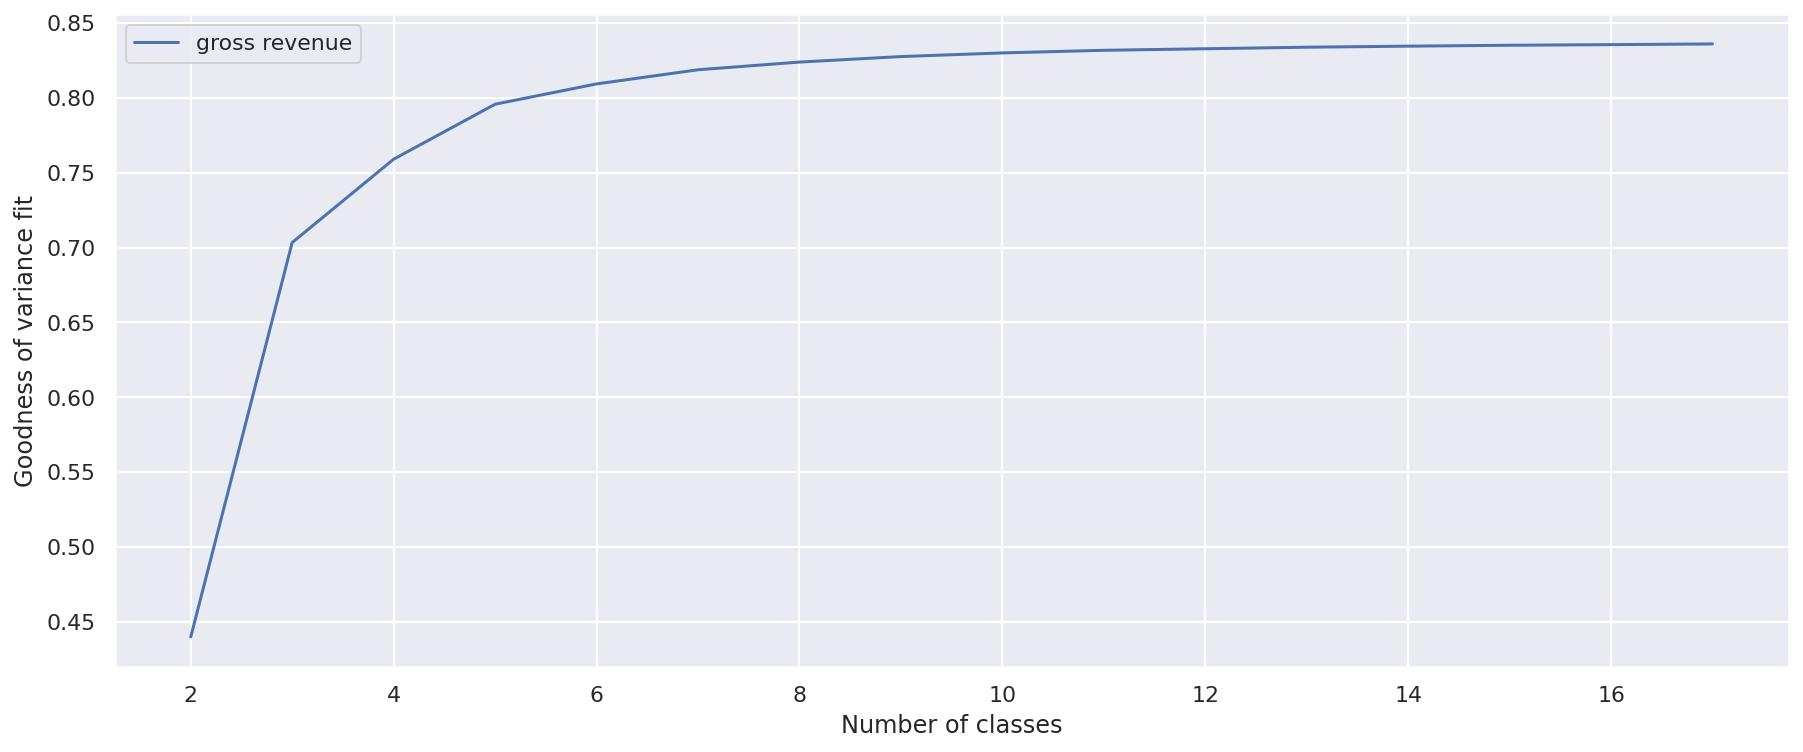

In [45]:
my_dict = {}
for col in df.columns[2:]:
    results = []
    for i in range(2, 18):
        results.append(goodness_of_variance_fit(df[col], i))
    my_dict[col] = results  

plt.plot(range(2, 18), my_dict['gross revenue ($)'], label = 'gross revenue')
plt.xlabel('Number of classes')
plt.ylabel('Goodness of variance fit')
plt.legend(loc = 'best')
plt.show()

In [46]:
my_dict

{'gross revenue ($)': [0.44014878299630383,
  0.703328942770766,
  0.7589345683371831,
  0.7956197701353557,
  0.8091705098692181,
  0.8186002307963073,
  0.823731730786949,
  0.8274113917922667,
  0.8298461965219064,
  0.8315895628570126,
  0.8326266484870847,
  0.8336542478603426,
  0.8343522015308557,
  0.8349587809660267,
  0.8353658257073389,
  0.8358409252902753]}

Based on the evaluation performed, we decided on using 5 breaks.

**Create a Jenks breaks classification**

We can move on to creating the Jenks breaks classification. To do this you simply pass the Pandas dataframe column to the jenks_breaks( ) function of jenkspy along with the number of classes you wish to create.

In [47]:
jenks_breaks = jenkspy.jenks_breaks(df['gross revenue ($)'], nb_class = 5)

If we print the output from the Jenks breaks classification, we’ll get back a list of values representing the bounds for each break or natural split identified.

In [48]:
jenks_breaks

[0.0, 256.0, 804.0, 1925.0, 3825.0, 14935.0]

Next we’ll use the values from jenks_breaks to identify the upper and lower bound for order values within each of the AOV classes the Jenks natural splits classification has identified. We’ll assign these labels as strings and put them back into the dataframe.

In [49]:
jenks_labels = [str(jenks_breaks[0]) + ' to ' + str(jenks_breaks[1]) + ' USD',
                str(jenks_breaks[1]) + ' to ' + str(jenks_breaks[2]) + ' USD',    
                str(jenks_breaks[2]) + ' to ' + str(jenks_breaks[3]) + ' USD',
                str(jenks_breaks[3]) + ' to ' + str(jenks_breaks[4]) + ' USD',    
                str(jenks_breaks[4]) + ' to ' + str(jenks_breaks[5]) + ' USD']

df['jenks break'] = pd.cut(df['gross revenue ($)'], bins = jenks_breaks, labels = jenks_labels)

In [50]:
df.head()

,transaction id,product type,gross revenue ($),jenks break
0,57682083-0ac9-45b3-8b03-b947d2ce0383,Art & Sculpture,14935.0,3825.0 to 14935.0 USD
1,2553db8c-08ea-428f-8411-ac0050e0755c,Basket,3744.0,1925.0 to 3825.0 USD
2,6f034733-959f-488c-8609-23370e359212,Basket,3825.0,1925.0 to 3825.0 USD
3,43dbb301-8900-47c2-abe4-23155335ffaa,Basket,3035.0,1925.0 to 3825.0 USD
4,d3a0065b-2822-480f-a55e-553449f567b0,Art & Sculpture,2696.8,1925.0 to 3825.0 USD


Now each transaction has been labelled with the class generated by the Jenks natural breaks classification we can create another Pandas Dataframe to summarise the data. To do this we’ll group by the jenks_break column label and use agg( ) to aggregate the data and calculate the number of orders and gross sales at each of the Jenks breaks.

In [51]:
df_breaks = df.groupby('jenks break').agg(orders = ('transaction id', 'count'), gross_revenue_in_dollars = ('gross revenue ($)', sum)).sort_values(by = 'orders', ascending = False).reset_index().head(5)

In [52]:
df_breaks

,jenks break,orders,gross_revenue_in_dollars
0,0.0 to 256.0 USD,1464,138132.80
1,256.0 to 804.0 USD,235,100293.25
2,804.0 to 1925.0 USD,66,78340.50
3,1925.0 to 3825.0 USD,8,22715.80
4,3825.0 to 14935.0 USD,1,14935.00


**Visualise the orders in each break**

To get a better impression of the contribution generated by each Jenks natural split class we can use a Seaborn barplot. This clearly shows that the bulk of orders are small and lower in value.

Text(0.5, 0, 'Jenks natural split')

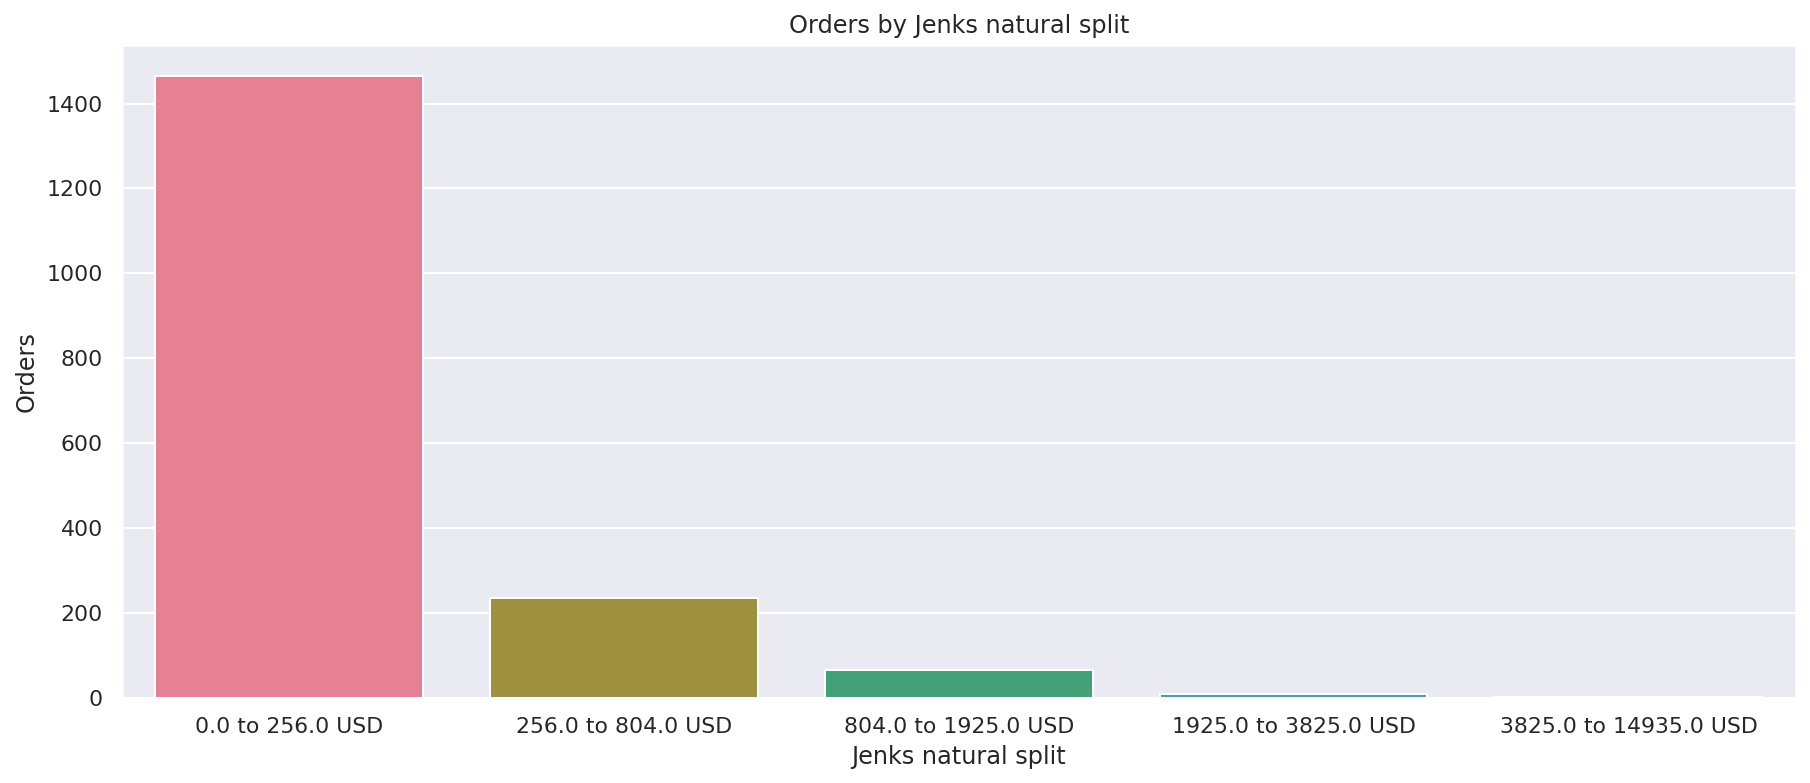

In [53]:
plot = sns.barplot(x = 'jenks break', y = 'orders', data = df_breaks, estimator = sum, palette = 'husl')
plot.set_title('Orders by Jenks natural split')
plot.set_ylabel('Orders')
plot.set_xlabel('Jenks natural split')

**Visualise the gross revenue generated from each break**

Finally, we can repeat the process by pass in the gross_revenue column to see how gross revenue contribution is distributed across the Jenks natural split classes. Those low value orders contribute the most as far as individual classes are concerned, but the higher value breaks contribute significantly more gross revenue overall.

Text(0.5, 0, 'Jenks natural split')

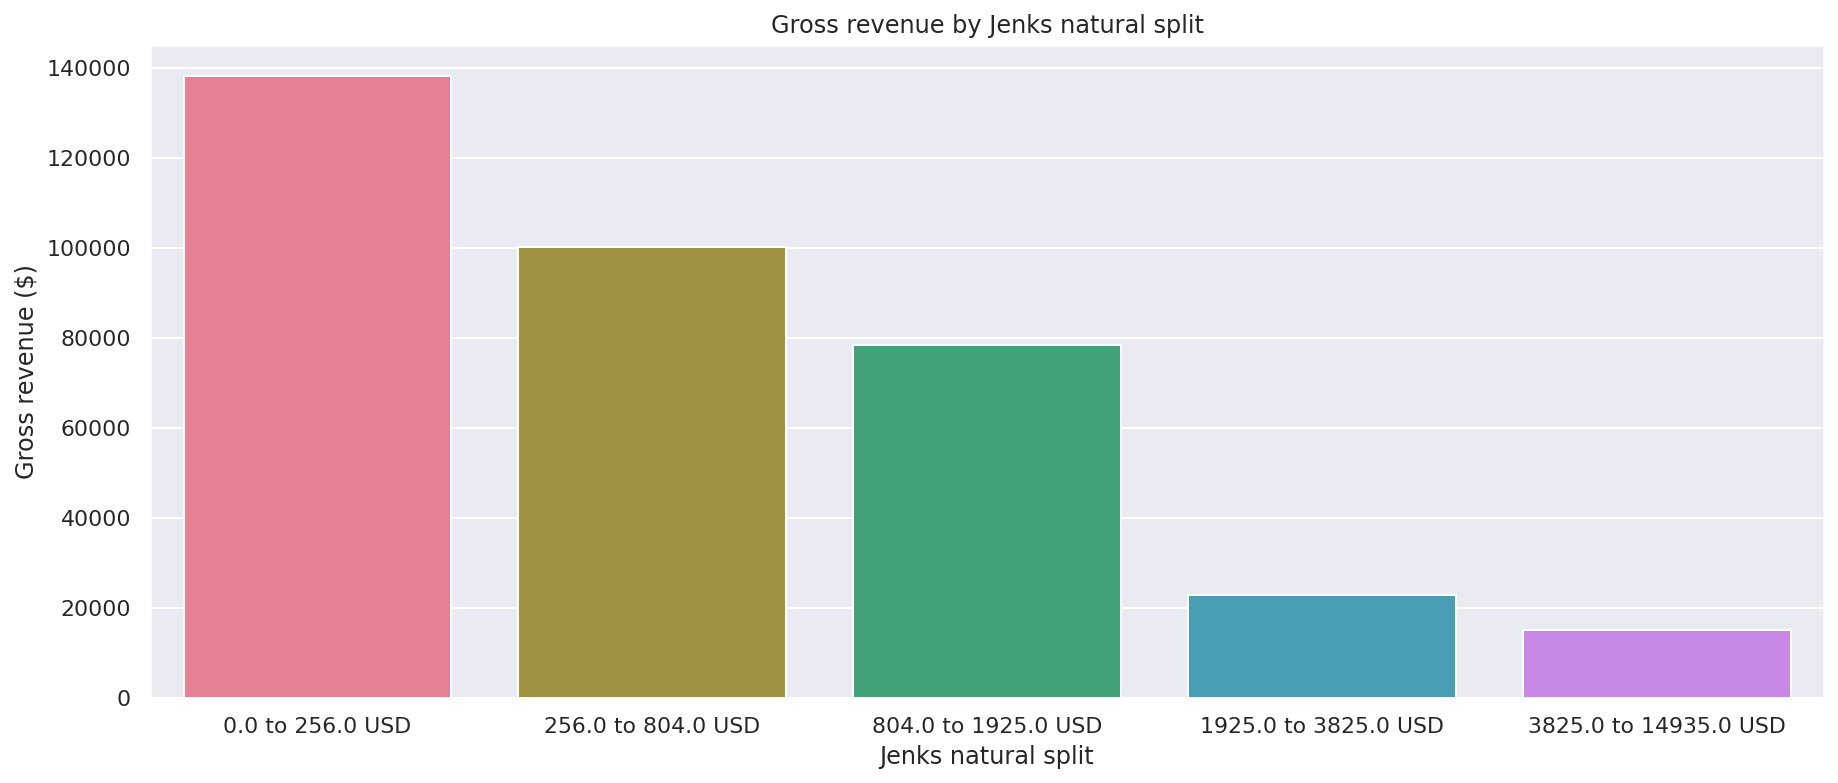

In [54]:
plot = sns.barplot(x = 'jenks break', y = 'gross_revenue_in_dollars', data = df_breaks, estimator = sum, palette = 'husl')
plot.set_title('Gross revenue by Jenks natural split')
plot.set_ylabel('Gross revenue ($)')
plot.set_xlabel('Jenks natural split')

**Setting free delivery thresholds**

By using Jenks natural splits we can identify where the delivery threshold should be positioned. For example, in the data above, I’d propose testing a free delivery threshold around the `$256` mark to encourage customers in the first break to stretch and spend a little more.